# Combined spectra_example 

# import 

In [1]:
import os
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import lineid_plot
from ramandecompy import spectrafit
from ramandecompy import peakidentify
from ramandecompy import dataprep
from ramandecompy import datavis
from ramandecompy import dataimport
from ramandecompy import machine_learning
from scipy import interpolate

In [2]:
dataprep.new_hdf5('combined_calibration_dataset')
dataprep.add_calibration('combined_calibration_dataset.hdf5', '../ramandecompy/tests/test_files/water.xlsx', 'water')
dataprep.add_calibration('combined_calibration_dataset.hdf5', '../ramandecompy/tests/test_files/Hydrogen_Baseline_Calibration.xlsx', 'hydrogen')
dataprep.add_calibration('combined_calibration_dataset.hdf5', '../ramandecompy/tests/test_files/Methane_Baseline_Calibration.xlsx', 'methane')
dataprep.add_calibration('combined_calibration_dataset.hdf5', '../ramandecompy/tests/test_files/CarbonMonoxide_Baseline_Calibration.xlsx', 'carbon monoxide')
dataprep.add_calibration('combined_calibration_dataset.hdf5', '../ramandecompy/tests/test_files/CO2_100wt%.csv', 'carbon dioxide')
dataprep.add_calibration('combined_calibration_dataset.hdf5', '../ramandecompy/tests/test_files/sapphire.xlsx', 'sapphire')
dataprep.add_calibration('combined_calibration_dataset.hdf5', '../ramandecompy/tests/test_files/Propane_test.xlsx', 'Propane')
dataprep.add_calibration('combined_calibration_dataset.hdf5', '../ramandecompy/tests/test_files/Ethane_test.xlsx', 'Ethane')
dataprep.add_calibration('combined_calibration_dataset.hdf5', '../ramandecompy/tests/test_files/Acetaldehyde_test.xlsx', 'Acetaldehyde')

Data from ../ramandecompy/tests/test_files/water.xlsx fit with compound pseudo-Voigt model. Results saved to combined_calibration_dataset.hdf5.
Data from ../ramandecompy/tests/test_files/Hydrogen_Baseline_Calibration.xlsx fit with compound pseudo-Voigt model. Results saved to combined_calibration_dataset.hdf5.
Data from ../ramandecompy/tests/test_files/Methane_Baseline_Calibration.xlsx fit with compound pseudo-Voigt model. Results saved to combined_calibration_dataset.hdf5.
Data from ../ramandecompy/tests/test_files/CarbonMonoxide_Baseline_Calibration.xlsx fit with compound pseudo-Voigt model. Results saved to combined_calibration_dataset.hdf5.
Data from ../ramandecompy/tests/test_files/CO2_100wt%.csv fit with compound pseudo-Voigt model. Results saved to combined_calibration_dataset.hdf5.
Data from ../ramandecompy/tests/test_files/sapphire.xlsx fit with compound pseudo-Voigt model. Results saved to combined_calibration_dataset.hdf5.
Data from ../ramandecompy/tests/test_files/Propane_t

[[array([0.00030748, 0.00031125, 0.00031662, ..., 0.27455696, 0.26655959,
         0.25878074]),
  array([0.00071157, 0.00072051, 0.00073057, ..., 0.09798014, 0.09515467,
         0.09240714]),
  array([0.00040751, 0.00043503, 0.0004765 , ..., 0.19648141, 0.19075634,
         0.18521581]),
  array([0.00057981, 0.00060446, 0.00064068, ..., 0.17950812, 0.17429481,
         0.16924694]),
  array([0.00066319, 0.00068263, 0.00070972, ..., 0.31175692, 0.30267211,
         0.29384812]),
  array([0.00056958, 0.00059643, 0.00063541, ..., 0.18923218, 0.18372011,
         0.17838271]),
  array([0.00061549, 0.00063232, 0.00065577, ..., 0.29792213, 0.28924243,
         0.28081045]),
  array([0.00028021, 0.00030206, 0.00033595, ..., 0.12442945, 0.12081453,
         0.11732336]),
  array([0.0003447 , 0.00035811, 0.00037747, ..., 0.15693447, 0.15236127,
         0.147924  ]),
  array([0.00069614, 0.00070536, 0.00071622, ..., 0.29390142, 0.28534729,
         0.27702638])],
 [array([0.00059579, 0.000627

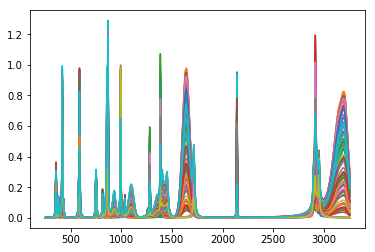

In [3]:
# first a function that will return a normalized interpolated spectra
target_compound = 'water'
# compound = 'water'
hdf5_filename = 'combined_calibration_dataset.hdf5'
spectra_count = 10
hdf5 = h5py.File(hdf5_filename, 'r')
# get list of compounds from hdf5 file
y_data_list = []
compound_list = list(hdf5.keys())
for target_compound in compound_list:
    x_data, y_data, labels = machine_learning.generate_spectra_dataset(hdf5_filename, target_compound, spectra_count)
    y_data_list.append(y_data)
len(x_data)
y_data_list

In [4]:
from sklearn.model_selection import train_test_split

# divide and extract test/train and validation data

X_train, X_test, y_train, y_test = train_test_split(y_data, labels, test_size=0.2)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

8 8
2 2


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression


logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')

# Create an instance of Logistic Regression Classifier and fit the data.
logreg.fit(X_train, y_train)

# get predictions
Z = logreg.predict(X_test)

logreg.score(X_test, y_test)

1.0

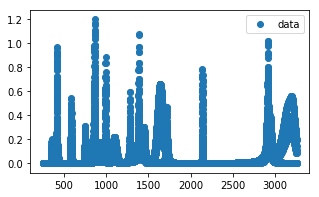

In [6]:



fig, ax = plt.subplots(figsize=(5, 3))
ax.scatter(x_data, y_data, label='data')
# ax.scatter(X_train, y_train, label='train')
# ax.scatter(X_test, y_test, label='teste')
# ax.scatter(X_test, regr.predict(X_test), label='predicted')

# fig, ax = plt.subplots(figsize=(5, 3))
# y = dat['fraction'].values
# x = dat['height'].values
# # Create the linear regression model
# LogRegr = linear_model.LogisticRegression() 
# # plotting the balance
# ax.scatter(dat['height'], dat['fraction'], label = 'balance default',color='r')

# # fit the linear model 
# LogRegr.fit(x.reshape(-1,1),y.reshape(-1,1))
# xres = np.array(x).reshape(-1,1)
# plt.plot(x,LogRegr.predict_proba(xres)[:,1],'o',label = 'fit')
# # Find the coefficients B0 and B1
# print('B0, B1: ',LogRegr.intercept_, LogRegr.coef_[0])
# ax.set_ylabel('Probability Default')
# ax.set_xlabel('Balance')
# ax.set_title('Probability Default vs. Balance')
plt.legend()

In [7]:
dataprep.new_hdf5('combined_calibration_cal')

In [8]:
hdf5_calfilename = 'combined_calibration_cal.hdf5' #update to hdf5_calfilename
key = 'cal'
for num, label in enumerate(labels):
    machine_learning.combine_experiment(hdf5_calfilename, key, x_data, y_data, label, num)

cal/0/residuals
Data from fit with compound pseudo-Voigt model.
          Results saved to combined_calibration_cal.hdf5.
cal/1/residuals
Data from fit with compound pseudo-Voigt model.
          Results saved to combined_calibration_cal.hdf5.
cal/2/residuals
Data from fit with compound pseudo-Voigt model.
          Results saved to combined_calibration_cal.hdf5.
cal/3/residuals
Data from fit with compound pseudo-Voigt model.
          Results saved to combined_calibration_cal.hdf5.
cal/4/residuals
Data from fit with compound pseudo-Voigt model.
          Results saved to combined_calibration_cal.hdf5.
cal/5/residuals
Data from fit with compound pseudo-Voigt model.
          Results saved to combined_calibration_cal.hdf5.
cal/6/residuals
Data from fit with compound pseudo-Voigt model.
          Results saved to combined_calibration_cal.hdf5.
cal/7/residuals
Data from fit with compound pseudo-Voigt model.
          Results saved to combined_calibration_cal.hdf5.
cal/8/residuals
Data fro

In [9]:
dataprep.view_hdf5(hdf5_calfilename)

**** combined_calibration_cal.hdf5 ****
cal
|    0
|    |    Peak_01
|    |    Peak_02
|    |    Peak_03
|    |    Peak_04
|    |    Peak_05
|    |    Peak_06
|    |    Peak_07
|    |    Peak_08
|    |    Peak_09
|    |    Peak_10
|    |    Peak_11
|    |    Peak_12
|    |    Peak_13
|    |    Peak_14
|    |    Peak_15
|    |    Peak_16
|    |    Peak_17
|    |    Peak_18
|    |    Peak_19
|    |    Peak_20
|    |    counts
|    |    residuals
|    |    wavenumber
|    1
|    |    Peak_01
|    |    Peak_02
|    |    Peak_03
|    |    Peak_04
|    |    Peak_05
|    |    Peak_06
|    |    Peak_07
|    |    Peak_08
|    |    Peak_09
|    |    Peak_10
|    |    Peak_11
|    |    Peak_12
|    |    Peak_13
|    |    Peak_14
|    |    Peak_15
|    |    Peak_16
|    |    Peak_17
|    |    Peak_18
|    |    Peak_19
|    |    Peak_20
|    |    counts
|    |    residuals
|    |    wavenumber
|    2
|    |    Peak_01
|    |    Peak_02
|    |    Peak_03
|    |    Peak_04
|    |    Peak_05
|    |   

In [10]:
hdf5 = h5py.File(hdf5_calfilename, 'r+')

In [11]:
key_list = machine_learning.keyfinder(hdf5_calfilename)
key_list

['cal/0',
 'cal/1',
 'cal/2',
 'cal/3',
 'cal/4',
 'cal/5',
 'cal/6',
 'cal/7',
 'cal/8',
 'cal/9']

In [12]:
hdf5_calfilename = 'combined_calibration_dataset.hdf5' #update to hdf5_calfilename
hdf5_expfilename = 'combined_calibration_cal.hdf5'
frames = []
for i,key in enumerate(key_list):
    df =peakidentify.peak_assignment(hdf5_expfilename, key, hdf5_calfilename, 50, plot =False)
    frames.append(df)

The peaks that we found for Acetaldehyde are: 
858.1315115115115
930.3443643643643
1098.8410210210209
1354.5948748748747
1402.7367767767767
1450.8786786786784
1715.659139139139
2928.233293293293
[0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1.]
The peaks that we found for Ethane are: 
993.5306106106106
2898.1446046046044
2952.3042442442443
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
The peaks that we found for Propane are: 
870.1669869869869
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The peaks that we found for carbon dioxide are: 
1280.4
1385.3
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
The peaks that we found for carbon monoxide are: 
2139.9096496496495
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
The peaks that we found for hydrogen are: 
355.6504104104104
587.3333133133133
816.0073473473473
1035.6547747747748
[1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The peaks that we found for 

(0.07571548889330476, 4.320330023185543, 2141.0, 2.17086952897656, 8.640660046371085, 0.23026274712591085, 2.170547023695556, "['carbon monoxide']")
(1.0, 8.188332266909839, 2915.0, 17.77298892824922, 16.376664533819678, 0.6908999169169979, 17.619379170255154, "['Acetaldehyde', 'Ethane', 'methane']")
(1.0, 99.9999999999898, 3194.0, 68.53458060292807, 199.9999999999796, 0.21815234551374088, 45.47527603867046, "['water']")
{'Acetaldehyde': 112.5, 'Ethane': 100.0, 'Propane': 100.0, 'carbon dioxide': 150.0, 'carbon monoxide': 100.0, 'hydrogen': 175.0, 'methane': 100.0, 'sapphire': 125.0, 'water': 100.0}
The peaks that we found for Acetaldehyde are: 
858.1315115115115
930.3443643643643
1098.8410210210209
1354.5948748748747
1402.7367767767767
1450.8786786786784
1715.659139139139
2928.233293293293
[0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1.]
The peaks that we found for Ethane are: 
993.5306106106106
2898.1446046046044
2952.3042442442443
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.

(0.5588769791056603, 98.72453549605271, 3195.0, 72.41382547137488, 197.44907099210542, 0.28246825973230416, 51.20689975381984, "['water']")
{'Acetaldehyde': 125.0, 'Ethane': 100.0, 'Propane': 200.0, 'carbon dioxide': 150.0, 'carbon monoxide': 100.0, 'hydrogen': 175.0, 'methane': 100.0, 'sapphire': 125.0, 'water': 100.0}
The peaks that we found for Acetaldehyde are: 
858.1315115115115
930.3443643643643
1098.8410210210209
1354.5948748748747
1402.7367767767767
1450.8786786786784
1715.659139139139
2928.233293293293
[0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1.]
The peaks that we found for Ethane are: 
993.5306106106106
2898.1446046046044
2952.3042442442443
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1.]
The peaks that we found for Propane are: 
870.1669869869869
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
The peaks that we found for carbon dioxide are: 
1280.4
1385.3
[0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
The peaks that we found for carbon monoxide are: 
2139.9096496496495
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
The 

{'Acetaldehyde': 112.5, 'Ethane': 100.0, 'Propane': 100.0, 'carbon dioxide': 50.0, 'carbon monoxide': 100.0, 'hydrogen': 150.0, 'methane': 200.0, 'sapphire': 150.0, 'water': 100.0}
The peaks that we found for Acetaldehyde are: 
858.1315115115115
930.3443643643643
1098.8410210210209
1354.5948748748747
1402.7367767767767
1450.8786786786784
1715.659139139139
2928.233293293293
[0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1.]
The peaks that we found for Ethane are: 
993.5306106106106
2898.1446046046044
2952.3042442442443
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
The peaks that we found for Propane are: 
870.1669869869869
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The peaks that we found for carbon dioxide are: 
1280.4
1385.3
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0.]
The peaks that we found for carbon monoxide are: 
2139.9096496496495
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
The peaks that we found for hydrogen are: 
355.6504104104104
587.3333133133133
816.0073473473473
103

(0.11326798959394102, 4.31238462124634, 2141.0, 5.8567334137094305, 8.62476924249268, 0.6146425889039469, 5.855434197001764, "['carbon monoxide']")
(0.9999999989224173, 10.434689302246541, 2915.0, 20.40581535800941, 20.869378604493082, 0.6224787896680661, 20.18109116581208, "['Acetaldehyde', 'Ethane', 'methane']")
(0.8573971503999152, 98.67311717469441, 3194.0, 152.70875922575453, 197.34623434938882, 0.5260388329601131, 103.84054524246372, "['water']")
{'Acetaldehyde': 125.0, 'Ethane': 100.0, 'Propane': 200.0, 'carbon dioxide': 150.0, 'carbon monoxide': 100.0, 'hydrogen': 175.0, 'methane': 100.0, 'sapphire': 125.0, 'water': 100.0}
The peaks that we found for Acetaldehyde are: 
858.1315115115115
930.3443643643643
1098.8410210210209
1354.5948748748747
1402.7367767767767
1450.8786786786784
1715.659139139139
2928.233293293293
[0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1.]
The peaks that we found for Ethane are: 
993.5306106106106
2898.1446046046044
2952.3042442442443
[0. 

(0.9845852445283099, 13.948201773451341, 2951.0, 11.11433346951002, 27.896403546902683, 0.2554983318803593, 10.936630645185314, "['Acetaldehyde', 'Ethane', 'methane']")
(0.5543331511323798, 99.99999999989578, 3194.0, 131.31499508335358, 199.99999999979156, 0.5065971624479554, 92.99343891756895, "['water']")
{'Acetaldehyde': 137.5, 'Ethane': 133.33333333333331, 'Propane': 200.0, 'carbon dioxide': 150.0, 'carbon monoxide': 100.0, 'hydrogen': 175.0, 'methane': 200.0, 'sapphire': 125.0, 'water': 100.0}


In [13]:
result = pd.concat(frames,axis=0, join='outer', join_axes=None, ignore_index=False,
          keys=None, levels=None, names=None, verify_integrity=False,
          copy=True,sort=True)

In [14]:
result

,0,1,2,3,4,5,6,7
0,0.694684,4.41784,355,1.02908,8.83568,0.0849146,1.01908,"['hydrogen', 'sapphire']"
0,1.02696e-14,3.95475,379,1.01587,7.90951,0.120659,1.01587,"['hydrogen', 'sapphire']"
0,0.725391,3.65163,417,9.41874,7.30326,0.928269,9.36811,['sapphire']
0,0.207451,3.5822,577,1.25938,7.1644,0.154095,1.25836,"['hydrogen', 'sapphire']"
0,0.546035,4.58475,587,2.65345,9.16949,0.224004,2.64636,"['hydrogen', 'sapphire']"
0,2.99239e-05,6.6829,750,4.03296,13.3658,0.283461,4.03296,['sapphire']
0,1.66533e-16,42.9195,815,2.04873,85.839,0.0224217,2.04873,"['Acetaldehyde', 'hydrogen']"
0,1,4.52197,868,13.6386,9.04394,0.960043,13.5985,"['Acetaldehyde', 'Propane']"
0,5.55112e-17,15.646,929,2.30483,31.292,0.0691948,2.30483,['Acetaldehyde']
0,0.755172,3.64813,993,6.2044,7.29627,0.604394,6.19466,"['Ethane', 'hydrogen']"


In [15]:
dat = pd.DataFrame()

In [16]:
#import the necessary module
from sklearn import preprocessing
# create the Labelencoder object
le = preprocessing.LabelEncoder()
dat['fraction']= result[:][0]
dat['sigma']= result[:][1]
# dat['center']= result[:][2]
dat['amplitude']= result[:][3]
dat['fwhm']= result[:][4]
dat['height']= result[:][5]
dat['auc']= result[:][6]
dat['labelencoded']=le.fit_transform(result[:][7])
dat['labels']= result[:][7]
dat['center']= result[:][2]

In [17]:
dat

,fraction,sigma,amplitude,fwhm,height,auc,labelencoded,labels,center
0,0.694684,4.41784,1.02908,8.83568,0.0849146,1.01908,9,"['hydrogen', 'sapphire']",355
0,1.02696e-14,3.95475,1.01587,7.90951,0.120659,1.01587,9,"['hydrogen', 'sapphire']",379
0,0.725391,3.65163,9.41874,7.30326,0.928269,9.36811,10,['sapphire'],417
0,0.207451,3.5822,1.25938,7.1644,0.154095,1.25836,9,"['hydrogen', 'sapphire']",577
0,0.546035,4.58475,2.65345,9.16949,0.224004,2.64636,9,"['hydrogen', 'sapphire']",587
0,2.99239e-05,6.6829,4.03296,13.3658,0.283461,4.03296,10,['sapphire'],750
0,1.66533e-16,42.9195,2.04873,85.839,0.0224217,2.04873,4,"['Acetaldehyde', 'hydrogen']",815
0,1,4.52197,13.6386,9.04394,0.960043,13.5985,2,"['Acetaldehyde', 'Propane']",868
0,5.55112e-17,15.646,2.30483,31.292,0.0691948,2.30483,5,['Acetaldehyde'],929
0,0.755172,3.64813,6.2044,7.29627,0.604394,6.19466,6,"['Ethane', 'hydrogen']",993


In [18]:
# dataprep.view_hdf5('ML_quad_calibration.hdf5')